In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from pyearth import Earth
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import VotingRegressor, StackingRegressor

In [3]:
data = pd.read_csv('data/merged_cleaned_processed.csv')

/var/folders/_r/zhgqwmg93t93tgtk01b4xvtc0000gn/T/ipykernel_16651/2997522077.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/merged_cleaned_processed.csv')


In [4]:
# suppressing warnings
import warnings
warnings.filterwarnings("ignore")

# data preprocessing

FEATURE REDUCTION
- Remove constant features
- Remove quasi-constant features
- Remove redundant features
- Print out correlation matrix
- Removing columns that have both a large number of missing values and low correlation w target variable


##### remove constant features

In [5]:
data.head()

,Unnamed: 0,date.x,location,year,mmwr_week,covid_19_deaths,date.y,distributed,distributed_janssen,distributed_moderna,...,month,region_East,region_Midwest,region_Puerto Rico,region_South,region_West,season_Fall,season_Spring,season_Summer,season_Winter
0,0,2020-01-04,AL,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
1,3780,2020-01-04,LA,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
2,9660,2020-01-04,VA,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
3,3570,2020-01-04,KY,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
4,3360,2020-01-04,KS,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,1


In [6]:
#### Remove constant features
constant_features = data.columns[data.nunique() == 1]
print(constant_features)

Index([], dtype='object')


No constant features

#### Remove quasi-constant features

In [7]:
#remove quasi-constant features
threshold = 0.95
quasi_constant = (data.var() <= threshold)

In [8]:
quasi_constant

Unnamed: 0         False
year               False
mmwr_week          False
covid_19_deaths    False
distributed        False
                   ...  
region_West         True
season_Fall         True
season_Spring       True
season_Summer       True
season_Winter       True
Length: 120, dtype: bool

In [9]:
series_dict = dict(zip(quasi_constant.index, quasi_constant.values))

In [10]:
series_dict

{'Unnamed: 0': False,
 'year': False,
 'mmwr_week': False,
 'covid_19_deaths': False,
 'distributed': False,
 'distributed_janssen': False,
 'distributed_moderna': False,
 'distributed_pfizer': False,
 'distributed_novavax': False,
 'distributed_unk_manuf': False,
 'dist_per_100k': False,
 'distributed_per_100k_5plus': False,
 'distributed_per_100k_12plus': False,
 'distributed_per_100k_18plus': False,
 'distributed_per_100k_65plus': False,
 'administered': False,
 'administered_5plus': False,
 'administered_12plus': False,
 'administered_18plus': False,
 'administered_65plus': False,
 'administered_janssen': False,
 'administered_moderna': False,
 'administered_pfizer': False,
 'administered_novavax': False,
 'administered_unk_manuf': False,
 'admin_per_100k': False,
 'admin_per_100k_5plus': False,
 'admin_per_100k_12plus': False,
 'admin_per_100k_18plus': False,
 'admin_per_100k_65plus': False,
 'recip_administered': False,
 'administered_dose1_recip': False,
 'administered_dose1_pop

In [11]:
for k,v in series_dict.items():
    if v == True:
        print(k)

region_East
region_Midwest
region_Puerto Rico
region_South
region_West
season_Fall
season_Spring
season_Summer
season_Winter


It would make sense that these are relatively constant so we will proceed without dropping anything

#### Remove redundant features

In [12]:
#remove redundant features
correlated_columns = data.corr().abs().columns[data.corr().abs().gt(0.25).any()]
correlated_columns.to_list()

['Unnamed: 0',
 'year',
 'mmwr_week',
 'covid_19_deaths',
 'distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'distributed_novavax',
 'distributed_unk_manuf',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_5plus',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'administered_novavax',
 'administered_unk_manuf',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_12plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_5plus',
 'administered_dose1_recip_5plus_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_12plus_pop_pct',
 'administered_dose1_recip_18plus',
 'administered_dose1_re

Our columns are pretty correlated

#### Print out correlation matrix

In [14]:
corr_matrix = data.corr().abs()
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                 Unnamed: 0      year  mmwr_week  covid_19_deaths  \
Unnamed: 0         1.000000  0.011262   0.009989         0.036129   
year               0.011262  1.000000   0.033363         0.159780   
mmwr_week          0.009989  0.033363   1.000000         0.003123   
covid_19_deaths    0.036129  0.159780   0.003123         1.000000   
distributed        0.047602  0.303141   0.038266         0.134438   
...                     ...       ...        ...              ...   
region_West        0.093032  0.035354   0.004936         0.039212   
season_Fall        0.009636  0.013964   0.555491         0.015092   
season_Spring      0.010516  0.006384   0.403033         0.057323   
season_Summer      0.001617  0.035391   0.065263         0.070978   
season_Winter      0.000929  0.040073   0.218917         0.133806   

                 distributed  distributed_janssen  distributed_moderna  \
Unnamed: 0          0.047602             0.051534             0.051563   
yea

In [15]:
correlation_matrix = data.corr()['covid_19_deaths']
print("Correlation Matrix with Target Variable:")
print(correlation_matrix)

Correlation Matrix with Target Variable:
Unnamed: 0        -0.036129
year              -0.159780
mmwr_week          0.003123
covid_19_deaths    1.000000
distributed        0.134438
                     ...   
region_West       -0.039212
season_Fall       -0.015092
season_Spring     -0.057323
season_Summer     -0.070978
season_Winter      0.133806
Name: covid_19_deaths, Length: 120, dtype: float64


<AxesSubplot:>

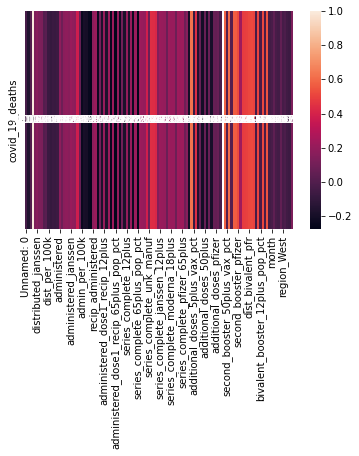

In [16]:
correlation_df = pd.DataFrame(correlation_matrix)
sns.heatmap(correlation_df.transpose(), annot=True)

#### Removing columns that have both a large number of missing values and low correlation w target variable

In [18]:
# Removing columns that have both a large number of missing 
# values and low correlation w target variable

threshold_missing = 0.5
threshold_corr = 0.2

target_corr = data.corr()['covid_19_deaths'].abs()
missing_values = data.isnull().mean()

In [19]:
target_corr

Unnamed: 0         0.036129
year               0.159780
mmwr_week          0.003123
covid_19_deaths    1.000000
distributed        0.134438
                     ...   
region_West        0.039212
season_Fall        0.015092
season_Spring      0.057323
season_Summer      0.070978
season_Winter      0.133806
Name: covid_19_deaths, Length: 120, dtype: float64

In [20]:
missing_values

Unnamed: 0       0.0
date.x           0.0
location         0.0
year             0.0
mmwr_week        0.0
                ... 
region_West      0.0
season_Fall      0.0
season_Spring    0.0
season_Summer    0.0
season_Winter    0.0
Length: 123, dtype: float64

In [21]:
to_drop_missing = data.columns[missing_values > threshold_missing]
to_drop_corr = target_corr[target_corr < threshold_corr].index

to_drop_combined = set(to_drop_missing).intersection(to_drop_corr)
to_drop_combined

{'additional_doses',
 'additional_doses_12plus_vax_pct',
 'additional_doses_5plus_vax_pct',
 'bivalent_booster_12plus_pop_pct',
 'bivalent_booster_18plus_pop_pct',
 'bivalent_booster_5plus_pop_pct',
 'bivalent_booster_65plus_pop_pct',
 'second_booster_50plus_vax_pct',
 'second_booster_65plus_vax_pct',
 'series_complete_unk_manuf_5plus'}